In [ ]:
!pip install timm
!pip install torchviz
!pip install onnx onnxruntime
!pip install datasets
# !huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=32ff2901a4d4e134ae32f89568e35a0823f834f0748a5ca24810dccab4e12c2a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00
INFO: pip is looking a

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
%cd /content/drive/MyDrive/OOD_2/
!ls

Mounted at /content/drive
/content/drive/MyDrive/OOD_2
checkpoints_mobilenet		     rnn_torchviz
checkpoints_resnet		     rnn_torchviz.png
CustomImageDataset.py		     SkinLesionRuzinClassifier_covariance0.npy
distances			     SkinLesionRuzinClassifier_covariance1.npy
evaluate_with_mcd.py		     SkinLesionRuzinClassifier_covariance2.npy
ham10000_images_part_1		     SkinLesionRuzinClassifier_covariance3.npy
HAM10000_images_part_1		     SkinLesionRuzinClassifier_covariance4.npy
HAM10000_images_part_2		     SkinLesionRuzinClassifier_covariance5.npy
HAM10000_metadata.csv		     SkinLesionRuzinClassifier_covariance6.npy
hmnist_28_28_L.csv		     SkinLesionRuzinClassifier_covariance.npy
hmnist_28_28_RGB.csv		     SkinLesionRuzinClassifier_mean0.npy
hmnist_8_8_L.csv		     SkinLesionRuzinClassifier_mean1.npy
hmnist_8_8_RGB.csv		     SkinLesionRuzinClassifier_mean2.npy
ISIC2018_Task3_Test_GroundTruth.csv  SkinLesionRuzinClassifier_mean3.npy
ISIC2018_Task3_Test_Images	     SkinLesionRuzinClassifier_m

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from CustomImageDataset import CustomImageDataset
from models.SkinLesionRuzinClassifier import SkinLesionRuzinClassifier
from imblearn.over_sampling import RandomOverSampler
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision
from evaluate_with_mcd import get_monte_carlo_predictions
from evaluate_with_mcd import get_monte_carlo_predictions_single_image
import torchvision.transforms as transforms
from mahalanobis_utils import *


# If the dataset is gated/private, make sure you have run huggingface-cli login
# dataset = load_dataset("zh-plus/tiny-imagenet", split= "valid")

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.3
# use a gpu if one is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

device =  cuda


In [ ]:
path_data = ''

In [ ]:
index_to_label_dict = {5: ('nv', ' melanocytic nevi'), 4: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 6: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}
label_to_index_dict = {'akiec' : 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv':5, 'vasc':6}

In [ ]:
test_data = pd.read_csv(path_data + 'ISIC2018_Task3_Test_GroundTruth.csv')
test_data.drop(axis = 0, index = 534, inplace = True)
test_data.head()

lesion_id      image_id   dx    dx_type   age     sex localization  \
0  HAMTEST_0000000  ISIC_0034524   nv  follow_up  40.0  female         back   
1  HAMTEST_0000001  ISIC_0034525   nv      histo  70.0    male      abdomen   
2  HAMTEST_0000002  ISIC_0034526  bkl      histo  70.0    male         back   
3  HAMTEST_0000003  ISIC_0034527   nv      histo  35.0    male        trunk   
4  HAMTEST_0000004  ISIC_0034528   nv  follow_up  75.0  female        trunk   

         dataset  
0  vidir_molemax  
1      rosendahl  
2      rosendahl  
3    vienna_dias  
4  vidir_molemax

In [ ]:
test_model = SkinLesionRuzinClassifier(7)
test_model.to(device)
test_model.load_state_dict(torch.load('checkpoints_mobilenet/final_model.pth'), strict=False)
test_model.eval()
# dict(test_model.named_parameters())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

SkinLesionRuzinClassifier(
  (model): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): ReLU(inplace=True)
            (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (gate): Hardsigmoid()
          )
          (conv_pw): Conv2d(16, 8, kernel_

# Plotting the model representation
Get a graphical representation of the model. Requires netron to be displayed, can be obtained here: https://github.com/lutzroeder/netron

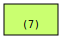

In [ ]:
import torch.onnx

random_img = np.random.random((1,3,450,600))

torch.onnx.export(test_model, torch.Tensor(random_img * 255).int().float().to(device), 'model.onnx', input_names=["image"], output_names=["probabilities"])

# Experimenting with Monte Carlo Dropout
What we see is that the model prediction in classes that aren't as represented in the original dataset are still not as certain (low mean and high variance) as the one with the most samples. Even though we tried to use data augmentation algorithms.

In [0]:
test_data = pd.read_csv(path_data + 'ISIC2018_Task3_Test_GroundTruth.csv')
test_data.drop(axis = 0, index = 534, inplace = True)

means_per_class = []
variances_per_class = []
for i in range(7):
    print("currently loooking at disease: ", index_to_label_dict[i])

    test_class_data = test_data[test_data['dx'] == index_to_label_dict[i][0]][0:16]
    print(np.shape(test_class_data))
    test_img_labels = pd.DataFrame(test_class_data['dx'])
    test_img_names = pd.DataFrame(test_class_data['image_id'])
    # here warning !!! you have to tell by what factor to scale the image values
    # without argument all the value in image will be divide by 255
    test_dataset = CustomImageDataset(test_class_data, img_dir =path_data + 'ISIC2018_Task3_Test_Images', pixel_values_divider = 255)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    test_features, test_labels = next(iter(test_dataloader))
    img = test_features[0].squeeze()
    # print("shape of the image: ", img.shape, "\n")

    disease_label = test_labels[0]
    print("\nDisease label: ", index_to_label_dict[disease_label.item()], f"{i}")
    model_output = test_model(img.float().to(device).view(1,3,450,600))
    # print(model_output)
    # print(nn.Softmax(dim = -1)(model_output))
    print("predicted: ",index_to_label_dict[model_output.argmax(-1).item()])
    #if img values between 0 and 255 then add .int()  to display
    plt.imshow(img.permute(1, 2, 0))
    plt.show()


    mcd_results = get_monte_carlo_predictions(data_loader=test_dataloader,nb_forward_passes= 100, model=test_model, n_classes=7, n_samples=16, device= device)

    means_per_class.append(mcd_results[0])

    variances_per_class.append(mcd_results[1])
    classes_names = [index_to_label_dict[i][0] for i in range(7)]
    sns.barplot(x = classes_names, y = np.mean(mcd_results[0], axis = 0))
    plt.show()
    sns.barplot(x = classes_names, y = np.mean(mcd_results[1], axis = 0))
    plt.show()

In [ ]:
# np.arange(0,7)
# predictions = get_monte_carlo_predictions(test_model, test_dataloader, 7, 10)
# sns.Barplot(x = np.arange(0,7), y = np.mean(predictions, axis = 0))

In [ ]:
random_img = np.random.random((1,3,450,600))
print(np.shape(random_img.squeeze()))
display_img = np.moveaxis(random_img.squeeze(),0,-1)
print(np.shape(display_img))
plt.imshow(display_img)
plt.show()
results = get_monte_carlo_predictions_single_image(torch.Tensor(random_img * 255).int().float().to(device), nb_forward_passes = 1000, model = test_model, n_classes = 7)


classes_names = [index_to_label_dict[i][0] for i in range(7)]
sns.barplot(x = classes_names, y = results[0])
plt.show()
sns.barplot(x = classes_names, y = results[1])
plt.show()


# OOD detection using mahalanobis distance
We use the dataset called ImageNet 1000 mini, which can be found here: https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000?resource=download
The boundary found is 948.121337890625

In [ ]:
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook


test_model
test_model.model.flatten.register_forward_hook(get_activation('end_of_mobile_net'))
test_model.model.classifier[1].register_forward_hook(get_activation('specialized_representation'))
random_img = np.random.random((1,3,450,600))
test_model.eval()
with torch.no_grad():
  output = test_model(torch.Tensor(random_img).float().to(device))
print(activation['end_of_mobile_net'].size())
print(activation['specialized_representation'].size())

torch.Size([1, 1024])
torch.Size([1, 512])


In [ ]:
batch_size = 64

metadata_df = pd.read_csv(path_data + 'HAM10000_metadata.csv')

train_unprocessed, validation = train_test_split(metadata_df, test_size=0.3, stratify=metadata_df['dx'],
                                                 random_state=42)
oversample = RandomOverSampler()
y = train_unprocessed['dx'];
x = train_unprocessed.drop(columns=['dx']);
OOD_train_data, y = oversample.fit_resample(x, y)
OOD_train_data['dx'] = y

OOD_train_dataset = CustomImageDataset(OOD_train_data, img_dir =path_data + 'ham10000_images_part_1', pixel_values_divider = 255)
OOD_train_data_loader = DataLoader(OOD_train_dataset, batch_size=batch_size, shuffle=True, drop_last= False)
# transforms.Compose([
#                                        transforms.ConvertImageDtype(torch.float),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomVerticalFlip(),
#                                        transforms.RandomAutocontrast()])

In [ ]:
mean =torch.tensor(np.load("SkinLesionRuzinClassifier_mean.npy" )).to(device)
covariance =torch.tensor(np.load("SkinLesionRuzinClassifier_covariance.npy" )).to(device)
inv_covariance_mat =  torch.linalg.inv(covariance).to(device)


In [ ]:
results = calculate_percentile_mahalanobis(input_data_loader = OOD_train_data_loader, model =  test_model, feature_size = 512,mean = mean, covariance = covariance, hook_name = "specialized_representation", save_distribution_parameters= False ,percentile = 0.95, index_to_label_dict= index_to_label_dict)
print(results[1])
result = results[0].sort_values(by = "distance")
# result.to_csv(f"distances/distances")
print(result.head())
print(result.iloc[int(0.95 * result.shape[0])])

## Displaying examples of mahalanobis distance calculation
What we see is that the images are in general very far from the distribution much more than the fixed threshold, which means the feature representation is good to differentiate between ID and OOD.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(393)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([4603.8140], device='cuda:0')


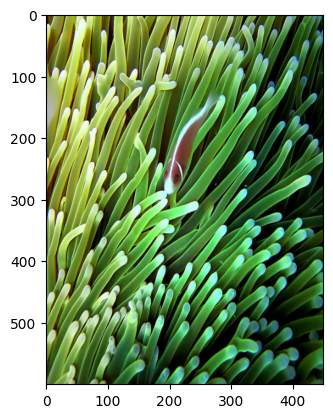

tensor(975)
predicted:  ('bcc', ' basal cell carcinoma')
mahalanobis distance :  tensor([15491.8828], device='cuda:0')


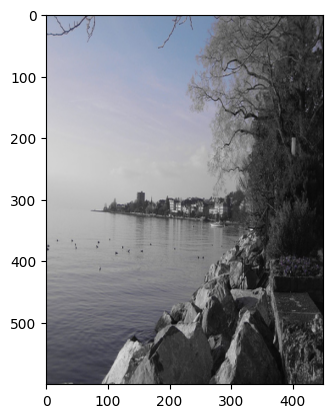

tensor(7)
predicted:  ('bkl', 'benign keratosis-like lesions')
mahalanobis distance :  tensor([11707.0498], device='cuda:0')


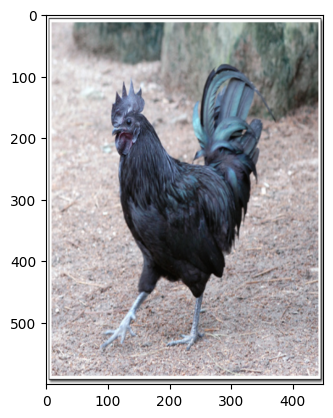

tensor(712)
predicted:  ('mel', 'melanoma')
mahalanobis distance :  tensor([183350.7344], device='cuda:0')


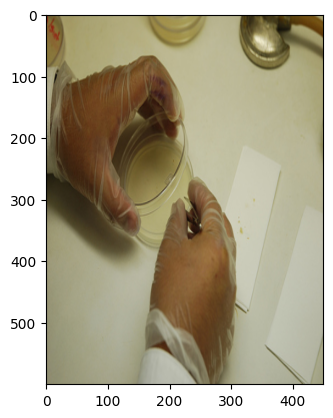

tensor(289)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([4687.6094], device='cuda:0')


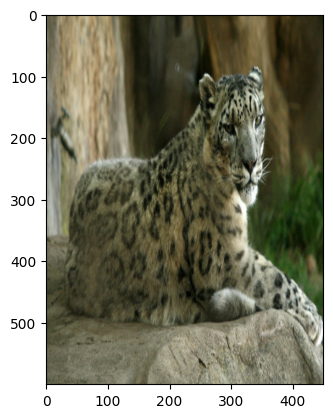

tensor(377)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([7682.6465], device='cuda:0')


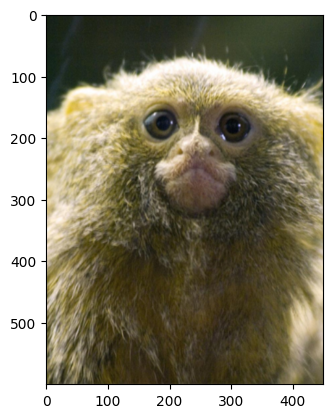

tensor(899)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([4030.9126], device='cuda:0')


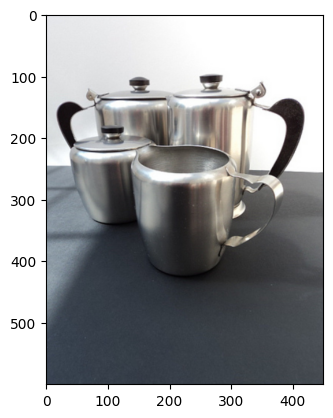

tensor(398)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([4674.2471], device='cuda:0')


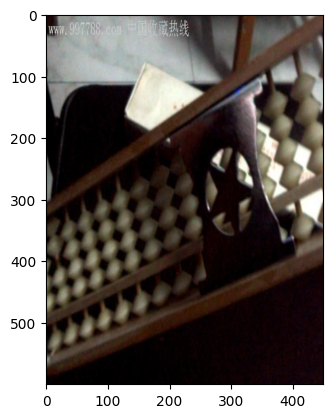

tensor(890)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([2495.2927], device='cuda:0')


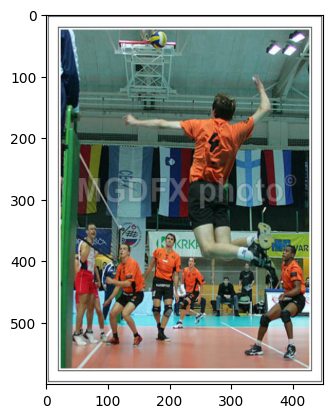

tensor(668)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([2484.2864], device='cuda:0')


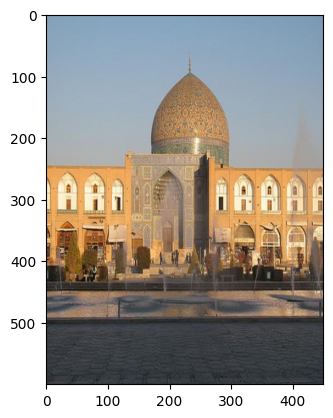

tensor(367)
predicted:  ('bcc', ' basal cell carcinoma')
mahalanobis distance :  tensor([844296.1250], device='cuda:0')


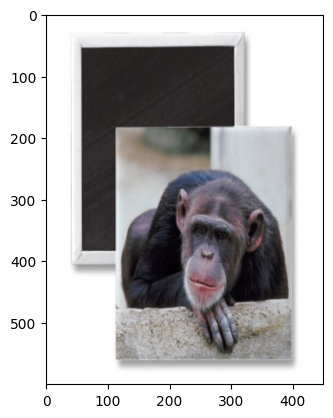

tensor(416)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([5174.6963], device='cuda:0')


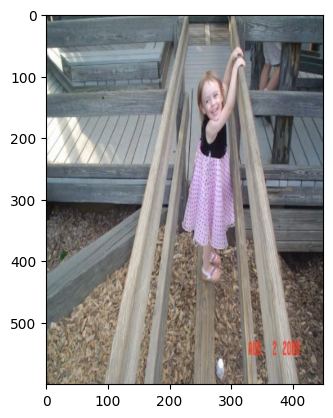

tensor(272)
predicted:  ('bkl', 'benign keratosis-like lesions')
mahalanobis distance :  tensor([8901.5781], device='cuda:0')


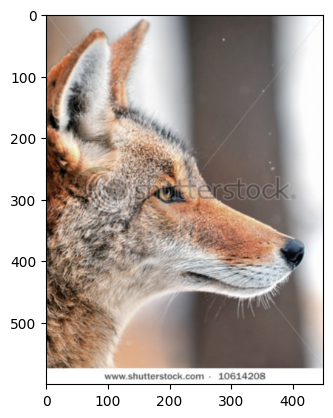

tensor(806)
predicted:  ('bkl', 'benign keratosis-like lesions')
mahalanobis distance :  tensor([19176.8418], device='cuda:0')


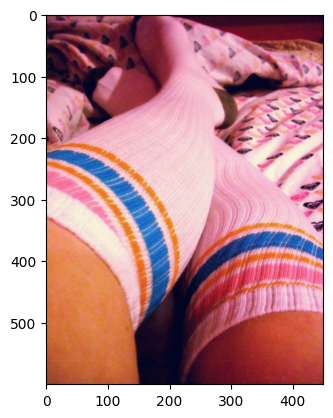

tensor(954)
predicted:  ('bkl', 'benign keratosis-like lesions')
mahalanobis distance :  tensor([7722.0635], device='cuda:0')


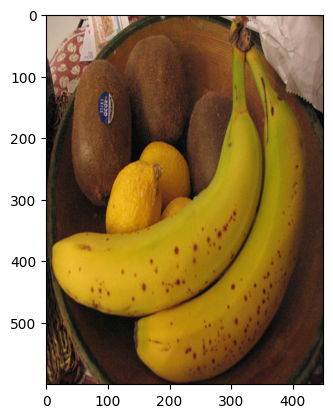

tensor(310)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  tensor([3313.0532], device='cuda:0')


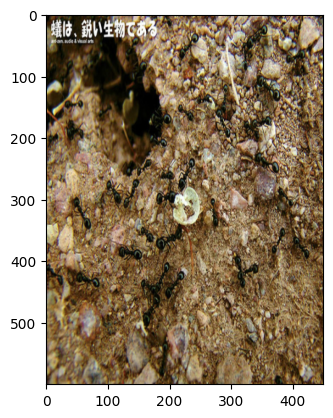

In [ ]:
batch_size = 16
mean = torch.tensor(np.load("SkinLesionRuzinClassifier_mean.npy")).to(device)
covariance = torch.tensor(np.load("SkinLesionRuzinClassifier_covariance.npy")).to(device)

dataset =  torchvision.datasets.ImageFolder(root= path_data + 'val', transform =
                                            transforms.Compose([transforms.ToTensor(),transforms.Resize((600,450))]))

test_model.to(device)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# print(next(iter(test_dataloader)))
test_input, test_labels = next(iter(test_dataloader))
for i in range(batch_size):
  # warning may need to be multiplied by 255
  img = test_input[i].squeeze()
  # print("shape of the image: ", img.shape, "\n")
  gt_label = test_labels[i]
  print(gt_label)
  # print("\nDisease label: ", index_to_label_dict[disease_label.item()], f"{i}")
  model_output = test_model(img.float().to(device).view(1,3,450,600))
  # print(model_output)
  # print(nn.Softmax(dim = -1)(model_output))
  print("predicted: ",index_to_label_dict[model_output.argmax(-1).item()])
  print("mahalanobis distance : ", calculate_mahalanobis(activation["specialized_representation"].to(device), mean, inv_covariance_mat))
  plt.imshow(img.permute(1, 2, 0))
  plt.show()

In [ ]:
# test_dataset = CustomImageDataset(test_data, img_dir = path_HAM10000 + 'ISIC2018_Task3_Test_Images', pixel_values_divider = 255)
OOD_dataset =  torchvision.datasets.ImageFolder(root= path_data + 'val', transform =
                                            transforms.Compose([transforms.ToTensor(),transforms.Resize((600,450))]))

test_dataloader = DataLoader(OOD_dataset, batch_size=16, shuffle=True)
print(test_model_with_OOD_detection(test_model, test_dataloader, max_tolerable_distance= 948, mean= mean, inv_covariance_mat = inv_covariance_mat, feature_name="specialized_representation", device = "cuda"))

###################
# test the model # 
###################
Test Loss: 100% OOD 	Test Accuracy: 100% OOD 	Proportion of samples considered : 0.0, 	Proportion of ood detected:  1.0
('100% OOD', '100% OOD')


# mahalanobis OOD class-conditioned detection
## Here we have to apply data augmentation, because of the data lack of images in certain classes. Indeed, if the number of samples is inferior to the number of dimensions of the representation then the matrix is singular. We thought that the matrix wasn't singular because of rounding errors in the calculation. 
## Even with linear data augmentation, the non linearity of the network assures us that the lines of the training samples matrix (matrix which contains the feature representation of all the training data) are not linearly dependent.

In [ ]:
max_tolerable_distances = []
means = []
inv_covariance_mats = []
batch_size = 128
metadata_df = pd.read_csv(path_data + 'HAM10000_metadata.csv')

train_unprocessed, validation = train_test_split(metadata_df, test_size=0.3, stratify=metadata_df['dx'],
                                                 random_state=42)
oversample = RandomOverSampler()

# This transformation part can be commented to see the results without data augmentation
y = train_unprocessed['dx'];
x = train_unprocessed.drop(columns=['dx']);
OOD_train_data, y = oversample.fit_resample(x, y)
OOD_train_data['dx'] = y
transformation = transforms.Compose([
                                       transforms.ConvertImageDtype(torch.float),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomAutocontrast()])



for i in tqdm(range(7)):

  # OOD_train_dataset = CustomImageDataset(OOD_train_data[OOD_train_data['dx'] == index_to_label_dict[i][0]], img_dir = path_HAM10000 + 'ham10000_images_part_1', transform = transformation)
  # OOD_train_loader = DataLoader(OOD_train_dataset, batch_size=batch_size, shuffle=True, drop_last= False)
  # results = calculate_percentile_mahalanobis(input_data_loader = OOD_train_loader, batch_size = batch_size, model =  test_model, feature_size = 512, hook_name = "specialized_representation", save_stats = True,  filename_suffix = f"{i}",percentile = 0.95)
  # print("\n", f"boundary for class {i} is",results[1], "\n")
  # result = results[0].sort_values(by = "distance")
  # result.to_csv(f"distances/class_conditioned_distances{i}")
  # max_tolerable_distances.append(result.iloc[int(0.95 * result.shape[0])]["distance"])
  # distance_tab = pd.read_csv(f"distances/class_conditioned_distances{i}")
  # max_tolerable_distances.append(distance_tab.iloc[int(0.95 * distance_tab.shape[0])]["distance"])


  mean = torch.tensor(np.load(f"SkinLesionRuzinClassifier_mean{i}.npy")).to(device)
  covariance = torch.tensor(np.load(f"SkinLesionRuzinClassifier_covariance{i}.npy")).to(device)
  means.append(mean)
  inv_covariance_mats.append(torch.linalg.inv(covariance).to(device))
  # After computing the covariance matrix, print it out for inspection
  # print("Covariance Matrix:")
  # print(covariance.shape)
  condition_number = np.linalg.cond(covariance.cpu().numpy())
  print("condition number is:", condition_number)
  # Similarly, print out the mean vector
  # print("Mean Vector:")
  # print(mean)

  # Set a small tolerance for considering eigenvalues close to zero
  tolerance = 1e-6
  eigenvalues, _ = np.linalg.eig(covariance.cpu().numpy())
  # print(eigenvalues)
  # Check if any eigenvalue is close to zero and if
  if np.any(np.abs(eigenvalues) < tolerance):
      print("The covariance matrix is close to being singular.")
  if  np.any(eigenvalues == 0):
    print("problem")
  if  np.any(eigenvalues < 0):
    print("The covariance matrix is not positive definite.")


max_tolerable_distances = [853.1402587890625 , 876.5696411132812 , 848.1026611328125 , 968.546875 , 851.5113525390625 , 1037.5899658203125 , 1031.752685546875]
# OOD_dataset =  torchvision.datasets.ImageFolder(root= path_data + 'val', transform =
#                                             transforms.Compose([transforms.ToTensor(),transforms.Resize((600,450))]))
# test_dataloader = DataLoader(OOD_dataset, batch_size=16, shuffle=True)


test_data = pd.read_csv(path_data + 'ISIC2018_Task3_Test_GroundTruth.csv')
test_data.drop(axis = 0, index = 534, inplace = True)
Classification_test_dataset = CustomImageDataset(test_data, img_dir =path_data + 'ISIC2018_Task3_Test_Images', pixel_values_divider = 255)
test_dataloader = DataLoader(Classification_test_dataset, batch_size=16, shuffle=True)

print(test_model_with_class_conditionned_OOD_detection(test_model, test_dataloader, max_tolerable_distances= max_tolerable_distances, means= means, inv_covariance_mats = inv_covariance_mats, feature_name="specialized_representation", device = "cuda"))

  0%|          | 0/7 [00:00<?, ?it/s]

Calculating distribution mean... 



100%|██████████| 37/37 [04:33<00:00,  7.39s/it]


Calculating distribution covariance... 



100%|██████████| 37/37 [01:33<00:00,  2.54s/it]


Calculating samples distance to distribution... 



100%|██████████| 37/37 [02:19<00:00,  3.76s/it]



 boundary for class 0 is 853.1402587890625 

533802.2


 14%|█▍        | 1/7 [08:28<50:48, 508.06s/it]

Calculating distribution mean... 



100%|██████████| 37/37 [06:14<00:00, 10.11s/it]


Calculating distribution covariance... 



100%|██████████| 37/37 [01:31<00:00,  2.48s/it]


Calculating samples distance to distribution... 



100%|██████████| 37/37 [02:22<00:00,  3.86s/it]



 boundary for class 1 is 876.5696411132812 

232017.56


 29%|██▊       | 2/7 [18:38<47:21, 568.31s/it]

Calculating distribution mean... 



100%|██████████| 37/37 [11:22<00:00, 18.44s/it]


Calculating distribution covariance... 



100%|██████████| 37/37 [01:34<00:00,  2.56s/it]


Calculating samples distance to distribution... 



100%|██████████| 37/37 [02:22<00:00,  3.86s/it]



 boundary for class 2 is 848.1026611328125 

114928.69


 43%|████▎     | 3/7 [34:00<48:38, 729.58s/it]

Calculating distribution mean... 



100%|██████████| 37/37 [02:32<00:00,  4.13s/it]


Calculating distribution covariance... 



100%|██████████| 37/37 [01:32<00:00,  2.51s/it]


Calculating samples distance to distribution... 



100%|██████████| 37/37 [02:21<00:00,  3.82s/it]



 boundary for class 3 is 968.546875 


 57%|█████▋    | 4/7 [40:28<29:44, 594.90s/it]

10518360.0
Calculating distribution mean... 



100%|██████████| 37/37 [11:34<00:00, 18.76s/it]


Calculating distribution covariance... 



100%|██████████| 37/37 [01:40<00:00,  2.70s/it]


Calculating samples distance to distribution... 



100%|██████████| 37/37 [02:20<00:00,  3.79s/it]



 boundary for class 4 is 851.5113525390625 

140045.7


 71%|███████▏  | 5/7 [56:04<23:56, 718.01s/it]

Calculating distribution mean... 



100%|██████████| 37/37 [1:02:46<00:00, 101.78s/it]


Calculating distribution covariance... 



100%|██████████| 37/37 [01:33<00:00,  2.53s/it]


Calculating samples distance to distribution... 



100%|██████████| 37/37 [02:19<00:00,  3.76s/it]



 boundary for class 5 is 1037.5899658203125 

81682.66


 86%|████████▌ | 6/7 [2:02:44<30:33, 1833.96s/it]

Calculating distribution mean... 



100%|██████████| 37/37 [02:48<00:00,  4.56s/it]


Calculating distribution covariance... 



100%|██████████| 37/37 [01:32<00:00,  2.50s/it]


Calculating samples distance to distribution... 



100%|██████████| 37/37 [02:17<00:00,  3.72s/it]



 boundary for class 6 is 1031.752685546875 

3058532.5


100%|██████████| 7/7 [2:09:25<00:00, 1109.37s/it]


###################
# test the model # 
###################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Loss: 100% OOD 	Test Accuracy: 100% OOD 	Proportion of samples considered : 0.0, 	Proportion of ood detected:  1.0
('100% OOD', '100% OOD')


tensor(4)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([11668.537], dtype=float32), array([6113.3203], dtype=float32), array([2983.4834], dtype=float32), array([136594.78], dtype=float32), array([3648.1519], dtype=float32), array([2117.8252], dtype=float32), array([28820.676], dtype=float32)]


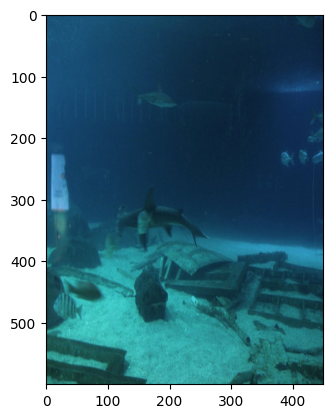

tensor(376)
predicted:  ('bcc', ' basal cell carcinoma')
mahalanobis distance :  [array([277305.94], dtype=float32), array([186261.34], dtype=float32), array([99550.875], dtype=float32), array([2176703.5], dtype=float32), array([110730.56], dtype=float32), array([90016.7], dtype=float32), array([1192874.9], dtype=float32)]


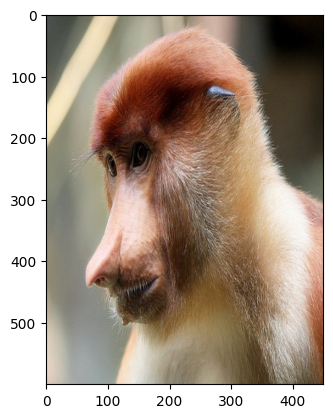

tensor(134)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([9259.455], dtype=float32), array([4665.9805], dtype=float32), array([2685.3594], dtype=float32), array([56705.363], dtype=float32), array([3702.1438], dtype=float32), array([1898.3303], dtype=float32), array([31322.998], dtype=float32)]


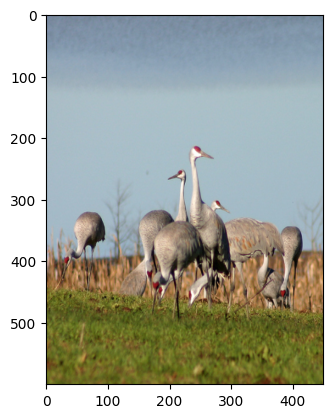

tensor(405)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([9871.928], dtype=float32), array([6684.111], dtype=float32), array([3618.5466], dtype=float32), array([98524.336], dtype=float32), array([4322.2056], dtype=float32), array([2516.8823], dtype=float32), array([32525.168], dtype=float32)]


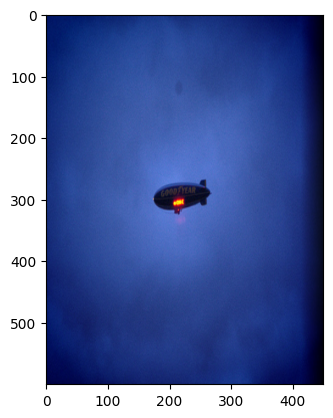

tensor(592)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([9375.043], dtype=float32), array([5600.004], dtype=float32), array([2530.1216], dtype=float32), array([87483.96], dtype=float32), array([4045.8252], dtype=float32), array([2789.6938], dtype=float32), array([39008.76], dtype=float32)]


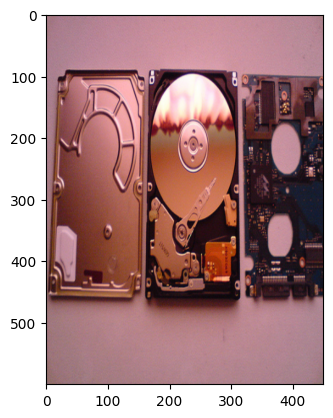

tensor(605)
predicted:  ('bkl', 'benign keratosis-like lesions')
mahalanobis distance :  [array([12190.428], dtype=float32), array([7429.394], dtype=float32), array([3769.8833], dtype=float32), array([106559.17], dtype=float32), array([5328.944], dtype=float32), array([3811.739], dtype=float32), array([51887.6], dtype=float32)]


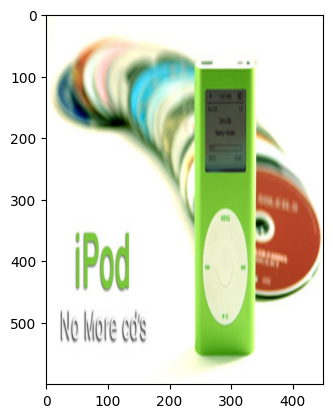

tensor(954)
predicted:  ('mel', 'melanoma')
mahalanobis distance :  [array([34163.867], dtype=float32), array([24185.312], dtype=float32), array([15624.592], dtype=float32), array([285977.94], dtype=float32), array([16034.141], dtype=float32), array([12791.149], dtype=float32), array([186307.72], dtype=float32)]


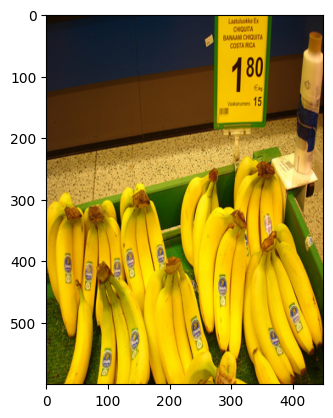

tensor(245)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([74479.17], dtype=float32), array([48492.676], dtype=float32), array([27902.027], dtype=float32), array([800245.25], dtype=float32), array([35597.61], dtype=float32), array([26192.498], dtype=float32), array([335771.62], dtype=float32)]


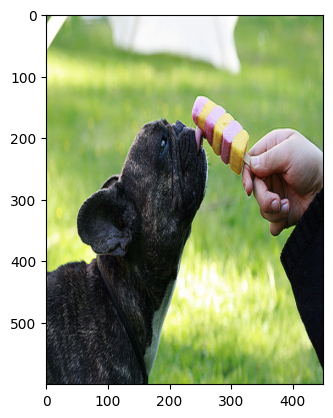

tensor(710)
predicted:  ('bcc', ' basal cell carcinoma')
mahalanobis distance :  [array([294653.88], dtype=float32), array([189197.9], dtype=float32), array([106404.74], dtype=float32), array([2636394.8], dtype=float32), array([118928.52], dtype=float32), array([98241.3], dtype=float32), array([1293449.2], dtype=float32)]


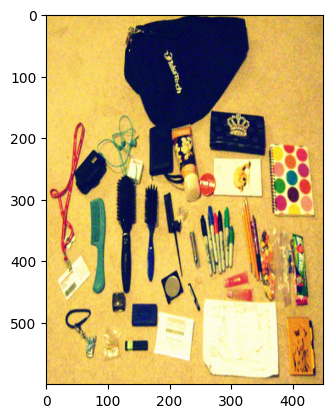

tensor(756)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([14341.446], dtype=float32), array([7032.2686], dtype=float32), array([3928.5747], dtype=float32), array([103548.42], dtype=float32), array([4838.9175], dtype=float32), array([3336.3708], dtype=float32), array([35550.51], dtype=float32)]


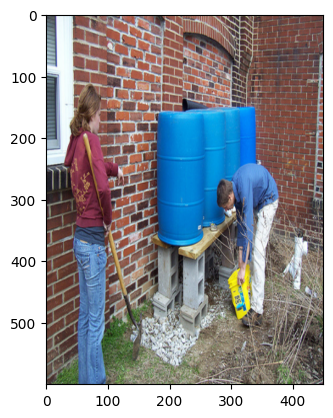

tensor(195)
predicted:  ('bcc', ' basal cell carcinoma')
mahalanobis distance :  [array([1055441.8], dtype=float32), array([597960.25], dtype=float32), array([364443.34], dtype=float32), array([9702737.], dtype=float32), array([440702.2], dtype=float32), array([373852.78], dtype=float32), array([4984438.5], dtype=float32)]


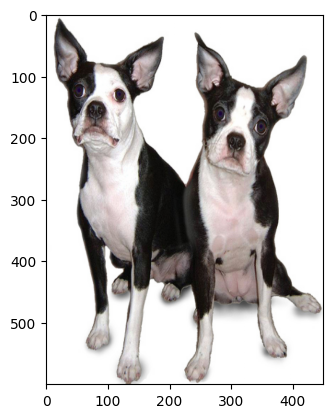

tensor(682)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([13870.556], dtype=float32), array([8606.82], dtype=float32), array([4624.2227], dtype=float32), array([119455.625], dtype=float32), array([6126.8853], dtype=float32), array([4450.164], dtype=float32), array([75081.44], dtype=float32)]


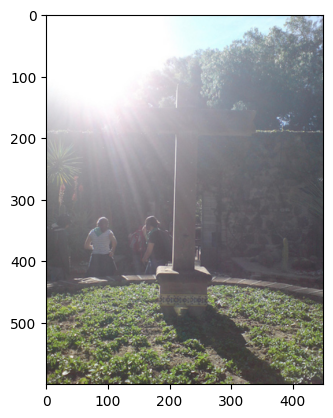

tensor(837)
predicted:  ('bkl', 'benign keratosis-like lesions')
mahalanobis distance :  [array([11404.584], dtype=float32), array([7078.836], dtype=float32), array([3783.155], dtype=float32), array([160253.81], dtype=float32), array([5054.6973], dtype=float32), array([3674.5522], dtype=float32), array([51599.875], dtype=float32)]


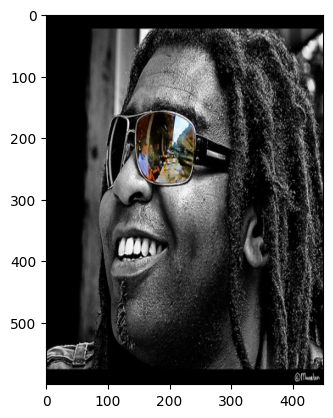

tensor(495)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([13357.211], dtype=float32), array([7083.324], dtype=float32), array([3847.328], dtype=float32), array([118672.82], dtype=float32), array([4607.498], dtype=float32), array([3044.018], dtype=float32), array([36927.88], dtype=float32)]


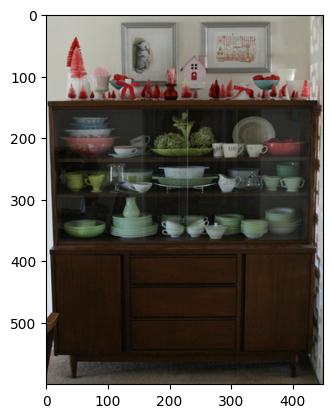

tensor(989)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([14532.541], dtype=float32), array([8754.8955], dtype=float32), array([4495.433], dtype=float32), array([120935.48], dtype=float32), array([6181.1875], dtype=float32), array([4386.873], dtype=float32), array([67651.51], dtype=float32)]


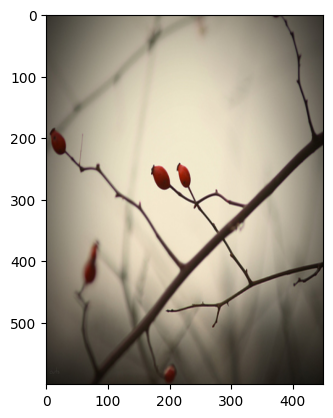

tensor(305)
predicted:  ('nv', ' melanocytic nevi')
mahalanobis distance :  [array([11656.855], dtype=float32), array([6188.5127], dtype=float32), array([3505.5112], dtype=float32), array([91163.67], dtype=float32), array([4615.5635], dtype=float32), array([2745.315], dtype=float32), array([35500.977], dtype=float32)]


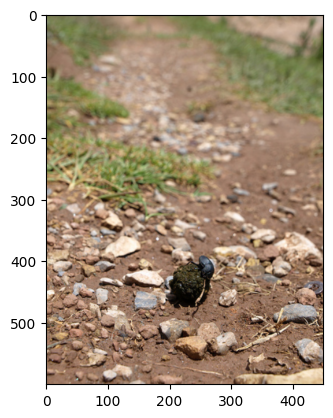

In [ ]:
batch_size = 16
dataset =  torchvision.datasets.ImageFolder(root= path_data + 'val', transform =
                                            transforms.Compose([transforms.ToTensor(),transforms.Resize((600,450))]))

test_model.to(device)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# print(next(iter(test_dataloader)))
test_input, test_labels = next(iter(test_dataloader))
for i in range(batch_size):
  # warning may need to be multiplied by 255
  img = test_input[i].squeeze()
  # print("shape of the image: ", img.shape, "\n")
  gt_label = test_labels[i]
  print(gt_label)
  # print("\nDisease label: ", index_to_label_dict[disease_label.item()], f"{i}")
  model_output = test_model(img.float().to(device).view(1,3,450,600))
  # print(model_output)
  # print(nn.Softmax(dim = -1)(model_output))
  print("predicted: ",index_to_label_dict[model_output.argmax(-1).item()])
  distances_from_distribution = []
  for i in range(len(means)):
   distances_from_distribution.append(calculate_mahalanobis(activation["specialized_representation"].to(device), means[i].to(device) , inv_covariance_mats[i]).cpu().numpy())
  print("mahalanobis distance : ", distances_from_distribution)
  plt.imshow(img.permute(1, 2, 0))
  plt.show()